## Imports y datasets

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from statistics import mean
from sklearn.linear_model import LogisticRegression
import pickle

RANDOM_STATE = 42

In [45]:
original = pd.read_csv('/content/hotels_procesado.csv').copy()
original_test = pd.read_csv('/content/hotels_test.csv').copy()
train = pd.read_csv('/content/train_encoded.csv').copy()
test = pd.read_csv('/content/test_encoded.csv').copy()

In [46]:
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

## Split train/test

In [47]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [48]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Normalizo los datos para obtener una mejor performance de los modelos.

In [49]:
stand_scaler = StandardScaler()
x_train = stand_scaler.fit_transform(x_train)
x_test = stand_scaler.transform(x_test)

## K-Nearest Neighbors (KNN)

Primero creamos el modelo con los parámetros por defecto

In [84]:
#Crear el modelo con parámetros por defecto
modelo_knn = KNeighborsClassifier()

In [85]:
#Entrenar el modelo
modelo_knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = modelo_knn.predict(x_test)

In [86]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.7256587202007528
f1 score: 0.7451483186665889


In [87]:
print(f'Best Training Accuracy: {modelo_knn.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_knn.score(x_test, y_test)}')

Best Training Accuracy: 0.8237255323725532
Best Testing Accuracy: 0.7256587202007528


### Aproximacion inicial a la cantidad de vecinos del modelo

In [89]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1,20) 

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))

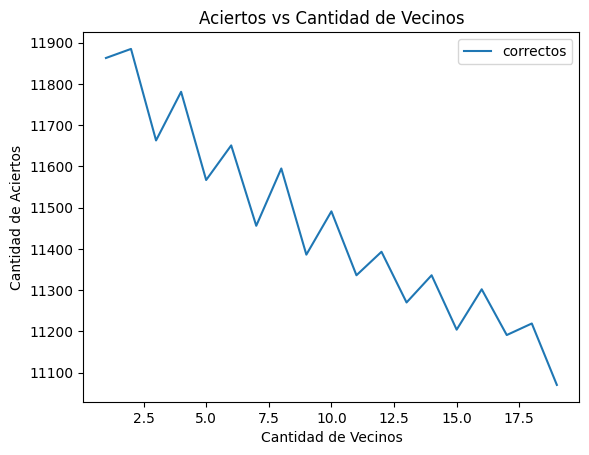

In [90]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de Aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [91]:
k_range = range(1,8) #cantidad de vecinos a probar

k_scores = [] 
scorer_fn = make_scorer(sk.metrics.f1_score)

for k in k_range:
    #clasificador Knn
    knn = KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring=scorer_fn)
    #promedio las 10 métricas
    k_scores.append(scores.mean())

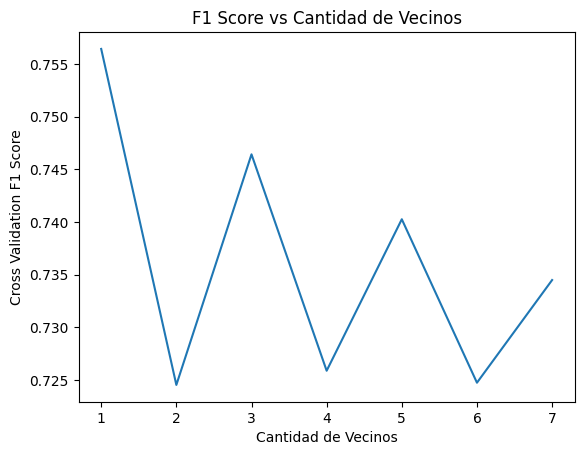

In [92]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1 Score')
plt.title('F1 Score vs Cantidad de Vecinos')
plt.show()

Ahora podemos tener una idea de que rango de vecinos poner para optimizar el modelo

### Random Search Cross Validation

In [ ]:
#Cantidad de combinaciones que quiero probar
n=3

#Grilla de Parámetros
params_grid={ 'n_neighbors':[1,3,5], 
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['manhattan'],
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
knn_model = KNeighborsClassifier()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_knn = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              n_jobs = -1,
                              random_state=RANDOM_STATE, verbose=2) 

rand_knn.fit(x_train, y_train)
rand_knn.cv_results_['mean_test_score']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
print('Mejores parámetros: {}'.format(rand_knn.best_params_))
print('Mejor métrica: {}'.format(rand_knn.best_score_))

In [ ]:
knn = KNeighborsClassifier().set_params(**rand_knn.best_params_)
modelo_knn = knn.fit(x_train, y_train)
y_pred = modelo_knn.predict(x_test)

### Métricas

In [ ]:
print(f'Best Training Accuracy: {modelo_knn.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_knn.score(x_test, y_test)}')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_knn.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [ ]:
pickle.dump(modelo_knn, open('knn_grupo29.pickle', 'wb'))

In [ ]:
X_submission_knn = test.select_dtypes(exclude=['object'])
y_pred_test_knn = modelo_knn.predict(X_submission_knn)
df_submission_knn = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_knn})
df_submission_knn.to_csv('knn03.csv', index=False)

## Support Vector Machine (SVM)

#### Modelo con parámetros por default

In [ ]:
#Crear el modelo con parámetros por defecto
SVM_Classifier = SVC()

In [ ]:
#Entrenar el modelo
modelo_svm = SVM_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = SVM_Classifier.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.84366373902133
Recall: 0.8552047360631475
Precision: 0.8402811439650993
f1 score: 0.8476772616136918


Ahora vamos a entrenar modelos de SVM variando el kernel y algunos parámetros

#### Kernel Lineal

In [ ]:
SVM_Lineal = SVC(kernel='linear', C=1)
modelo_svm = SVM_Lineal.fit(x_train, y_train)
y_pred = SVM_Lineal.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_svm.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Kernel Polinómico

In [ ]:
SVM_poly = SVC(kernel='poly', C=5, degree=10, gamma=10, coef0=10)
modelo_svm = SVM_poly.fit(x_train, y_train)
y_pred = SVM_poly.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_svm.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Kernel Radial

In [ ]:
SVM_radial = SVC(kernel='rbf', C=5, gamma=10)
modelo_svm = SVM_radial.fit(x_train, y_train)
y_pred = SVM_radial.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_svm.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Búsqueda de hiperparámetros

También quisimos hacer búsqueda de hiperparámetros para este modelo pero no pudimos correr estas celdas de código ya que el tiempo que tardaban era muy largo.

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'n_estimators': [10, 20, 30, 40, 50],
              'max_samples': [0.25, 0.5, 0.75, 1.0],
              'max_features': [0.1, 0.25, 0.5, 0.75, 1.0],
              }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
svm_model = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=5), random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_svm = RandomizedSearchCV(estimator = svm_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              n_jobs= 3,
                              random_state=RANDOM_STATE) 

rand_svm.fit(x_train, y_train)
rand_svm.cv_results_['mean_test_score']

In [ ]:
print('Mejores parámetros: {}'.format(rand_svm.best_params_))
print('Mejor métrica: {}'.format(rand_svm.best_score_))

Mejores parámetros: {'n_estimators': 10, 'max_samples': 0.25, 'max_features': 0.1}
Mejor métrica: 0.7201982349043664


In [ ]:
y_pred = rand_svm.best_estimator_.predict(x_test)

c:\Program Files\Python38\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5863237139272272
Recall: 0.830414405525407
Precision: 0.5633366800535475
f1 score: 0.6712861415752742


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.33      0.44      7832
           1       0.56      0.83      0.67      8108

    accuracy                           0.59     15940
   macro avg       0.61      0.58      0.56     15940
weighted avg       0.61      0.59      0.56     15940



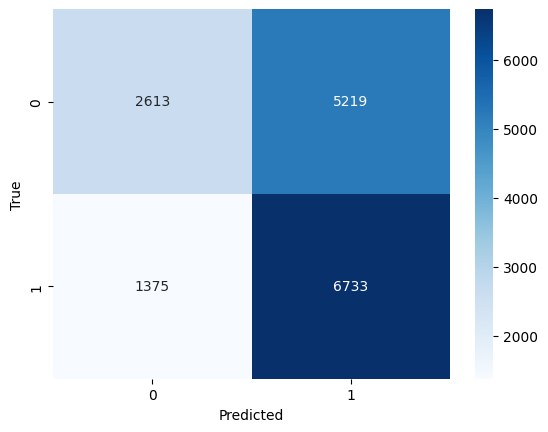

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission y conclusiones

El modelo con la mejor performance fue

In [ ]:
#pickle.dump(modelo_svm, open('svm_grupo29.pickle', 'wb'))

In [ ]:
X_submission_svm = test.select_dtypes(exclude=['object'])
y_pred_test_svm = modelo_svm.predict(X_submission_svm)
df_submission_svm = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_svm})
df_submission_svm.to_csv('svm00.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Random Forest

In [ ]:
modelo_rf = RandomForestClassifier()
modelo_rf.fit(x_train, y_train)
  
y_pred = modelo_rf.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.8741530740276036
f1 score: 0.8746719980007497


### Random Search Cross Validation

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators':      list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'max_depth':         [None],
                'max_samples':       np.linspace(0.5,1,n)
             }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
modelo_rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = modelo_rf,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score']

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.1s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.9s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   7.9s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   7.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   9.3s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   9.4s
[CV] END max_depth=None, max_samples=1.

array([0.87764186, 0.87255552, 0.87143985, 0.87335465, 0.87248101])

In [ ]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'n_estimators': 130, 'min_samples_split': 3, 'max_samples': 1.0, 'max_depth': None}
Mejor métrica: 0.8776418629671225


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
modelo_rf = rf.fit(x_train, y_train)
y_pred = modelo_rf.predict(x_test)

### Métricas

In [ ]:
print(f'Best Training Accuracy: {modelo_rf.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_rf.score(x_test, y_test)}')

Best Training Accuracy: 0.9954291245429124
Best Testing Accuracy: 0.8806148055207026


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8806148055207026
Recall: 0.8771583621114948
Precision: 0.8868936276343684
f1 score: 0.8819991318906182


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7832
           1       0.89      0.88      0.88      8108

    accuracy                           0.88     15940
   macro avg       0.88      0.88      0.88     15940
weighted avg       0.88      0.88      0.88     15940



In [ ]:
print(classification_report(y_train, modelo_rf.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18275
           1       0.99      1.00      1.00     18917

    accuracy                           1.00     37192
   macro avg       1.00      1.00      1.00     37192
weighted avg       1.00      1.00      1.00     37192



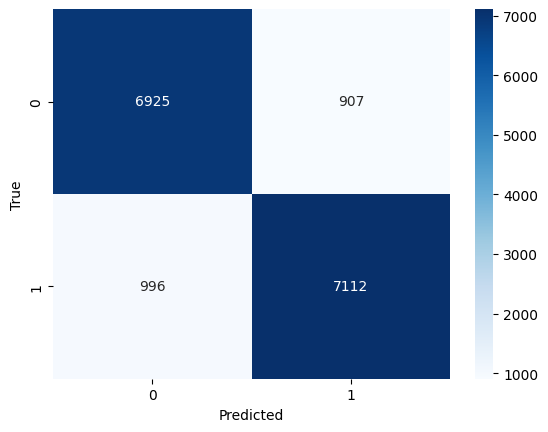

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualizacion del árbol y feature importance

In [ ]:
feat_imps = rf.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x.columns), reverse=True):
  if feat_imp > 0.01:
    print('{}: {}'.format(feat,feat_imp))

lead_time: 0.09424247011041242
country_PRT: 0.07725692538975933
deposit_type_Non Refund: 0.05498718429458808
total_of_special_requests: 0.052572140870440105
adr: 0.0500707741752953
deposit_type_No Deposit: 0.04906966582679281
stays_in_week_nights: 0.025075279637032877
required_car_parking_spaces: 0.021182238709646528
previous_cancellations: 0.019662077260996287
booking_changes: 0.019226724222215812
market_segment_Online TA: 0.017735133930335472
agent_10000: 0.017423472898257776
agent_9: 0.01660767900863189
stays_in_weekend_nights: 0.016386730968183945
customer_type_Transient: 0.01445066425000167
assigned_room_type_A: 0.013550622227748351
customer_type_Transient-Party: 0.01256027460621416
market_segment_Groups: 0.01213664025144553


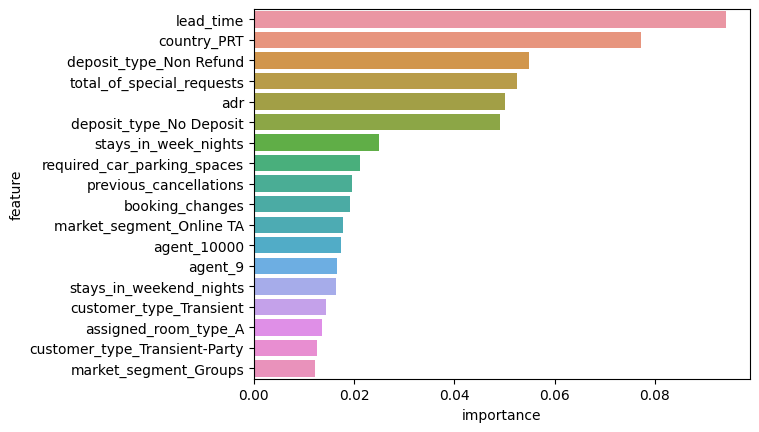

In [ ]:
feat_imp_df = pd.DataFrame({'feature':x.columns,'importance':feat_imps})
feat_imp_df = feat_imp_df[feat_imp_df['importance']>0.01]
feat_imp_df = feat_imp_df.sort_values(by='importance',ascending=False)
sns.barplot(x='importance',y='feature',data=feat_imp_df)
plt.show()

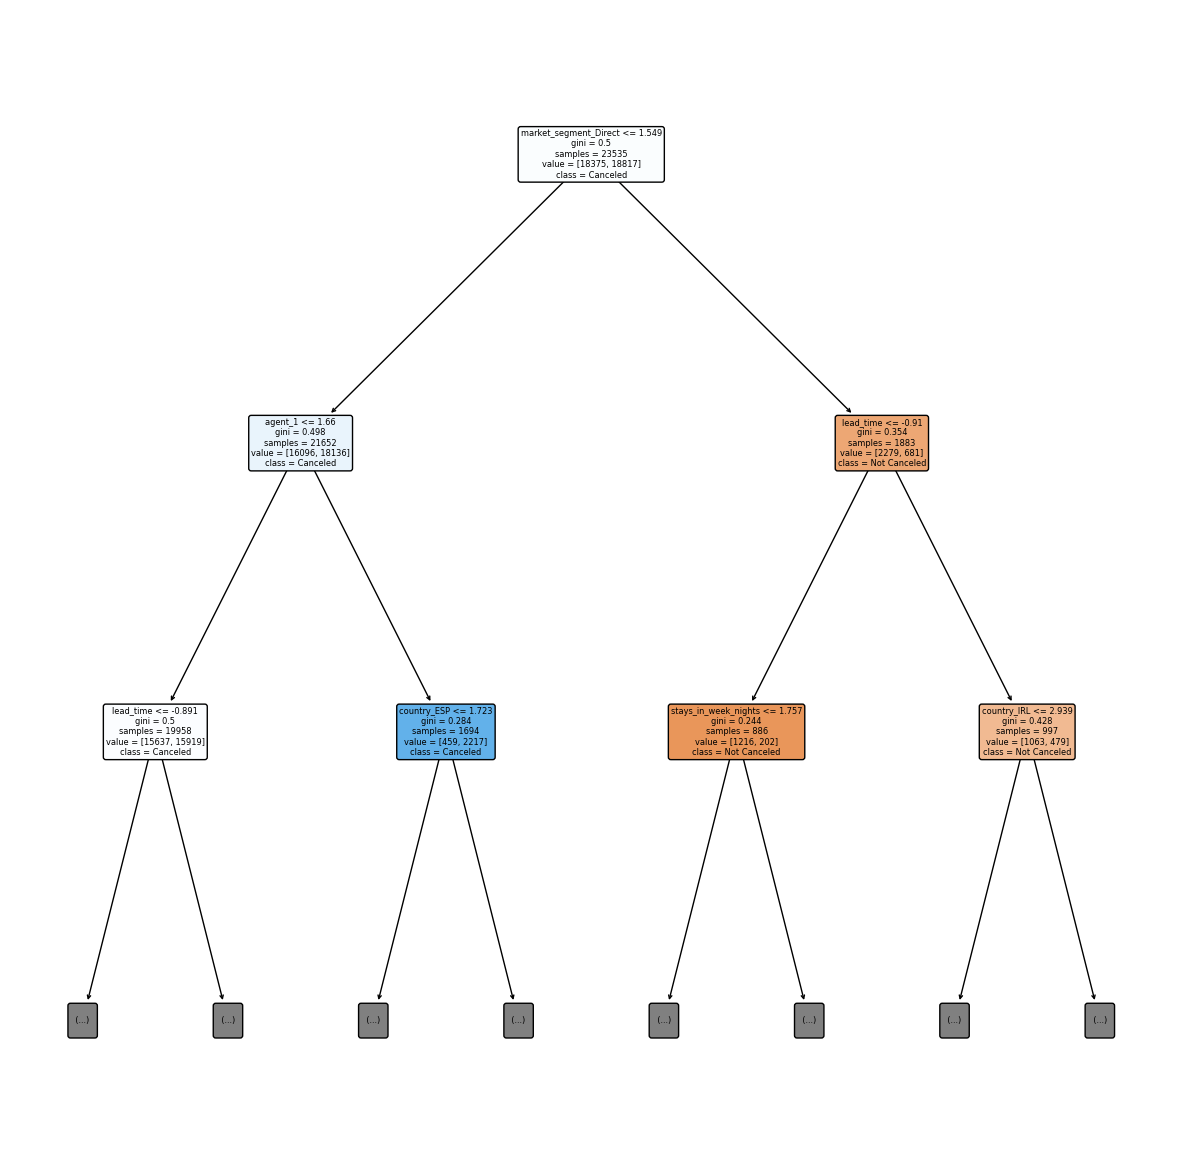

In [ ]:
plt.figure(figsize=(15, 15))

tree_plot = plot_tree(modelo_rf.estimators_[0],
                           max_depth=2,
                           feature_names=x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])
plt.show(tree_plot)

### Submission

In [55]:
pickle.dump(modelo_rf, open('rf_grupo29.pickle', 'wb'))

In [ ]:
X_submission_rf = test.select_dtypes(exclude=['object'])
y_pred_test_rf = modelo_rf.predict(X_submission_rf)
df_submission_rf = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_rf})
df_submission_rf.to_csv('rf02.csv', index=False)

## XGBoost

### Modelo con parámetros por default

In [ ]:
modelo_xgb = XGBClassifier(random_state=RANDOM_STATE)
modelo_xgb.fit(x_train, y_train)
y_pred = modelo_xgb.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.8718946047678795
f1 score: 0.8751223091976518


In [ ]:
print(f'Best Training Accuracy: {modelo_xgb.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_xgb.score(x_test, y_test)}')

Best Training Accuracy: 0.9065659281565929
Best Testing Accuracy: 0.8718946047678795


### Random Search Cross Validation

In [ ]:
#Cantidad de combinaciones que quiero probar
n=10

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }
folds = 5
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgb = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_xgb.fit(x_train, y_train)
rand_xgb.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  46.8s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  48.3s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  45.2s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  46.9s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  48.6s
[CV] END alpha=2, gamma=1, lambda=0, learning_rate=0.3346938775510204, max_depth=4, n_estimators=160, subsample=0.3684210526315789; total time=  25.6s
[CV] END alpha=2, gamma=1, lambda

array([0.87000869, 0.86074654, 0.8613553 , 0.8662935 , 0.85083807,
       0.85299663, 0.        , 0.83558883, 0.86701917, 0.85478763])

In [ ]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

Mejores parámetros: {'subsample': 0.5263157894736842, 'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.1969387755102041, 'lambda': 2, 'gamma': 2, 'alpha': 1}
Mejor métrica: 0.8700086861780193


In [ ]:
modelo_xgb = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
modelo_xgb.fit(x_train, y_train)
y_pred = modelo_xgb.predict(x_test)

### Métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8696361355081555
Recall: 0.8804884065120868
Precision: 0.8655431619786615
f1 score: 0.8729518219613597


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7832
           1       0.87      0.88      0.87      8108

    accuracy                           0.87     15940
   macro avg       0.87      0.87      0.87     15940
weighted avg       0.87      0.87      0.87     15940



In [ ]:
print(classification_report(y_train, modelo_xgb.predict(x_train)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     18275
           1       0.90      0.92      0.91     18917

    accuracy                           0.91     37192
   macro avg       0.91      0.91      0.91     37192
weighted avg       0.91      0.91      0.91     37192



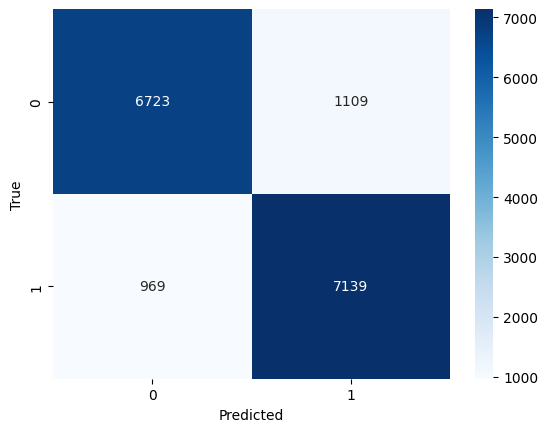

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [ ]:
pickle.dump(modelo_xgb, open('xgb_grupo29.pickle', 'wb'))

In [ ]:
X_submission_xgb = test.select_dtypes(exclude=['object'])
y_pred_test_xgb = modelo_xgb.predict(X_submission_xgb)
df_submission_xgb = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb01.csv', index=False)

## Voting Classifier

In [56]:
def score(model, X, y):
     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
     scores = cross_val_score(model, X, y, scoring='f1', cv=cv, error_score='raise')
     return scores

Primero creo los clasificadores

In [57]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=40)
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
knn = KNeighborsClassifier(n_neighbors=7)

Podemos evaluar la performance de cada uno de los clasificadores por separado 

In [58]:
models = {'random_forest': rf,
               'tree': tree,
               'knn': knn}

resultado, nombres = list(), list()
for nombre, model in models.items():
	scores = score(model, x_train, y_train)
	resultado.append(scores)
	nombres.append(nombre)
	print('%s %.3f' % (nombre, mean(scores)))

random_forest 0.871
tree 0.838
knn 0.728


Creamos el Voting Classifier, lo entrenamos con los datos y obtenemos las predicciones

In [59]:
#Creo ensemble de Votación
voting = VotingClassifier(estimators = [('random_forest', rf), ('tree', tree), ('knn', knn)], voting = 'hard', n_jobs=-1)

#Entreno el ensemble
modelo_voting = voting.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred = voting.predict(x_test)

Ahora evaluamos la performance del Voting Classifier

In [60]:
score_voting = score(voting, x_train, y_train)
print('Voting Classifier:', mean(score_voting))

Voting Classifier: 0.8594893037172796


In [61]:
resultado.append(score_voting)
nombres.append('voting')

In [62]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8631744040150564
Recall: 0.8660582141095214
Precision: 0.8650979425896267
f1 score: 0.8655778120184899


In [63]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7832
           1       0.87      0.87      0.87      8108

    accuracy                           0.86     15940
   macro avg       0.86      0.86      0.86     15940
weighted avg       0.86      0.86      0.86     15940



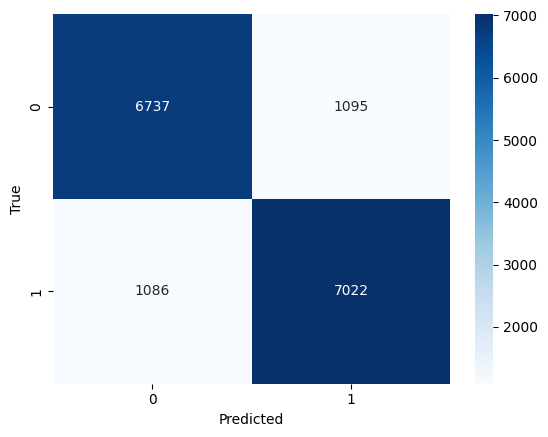

In [64]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ahora podemos comparar la performance de los modelos por separado con la del Voting Classifier

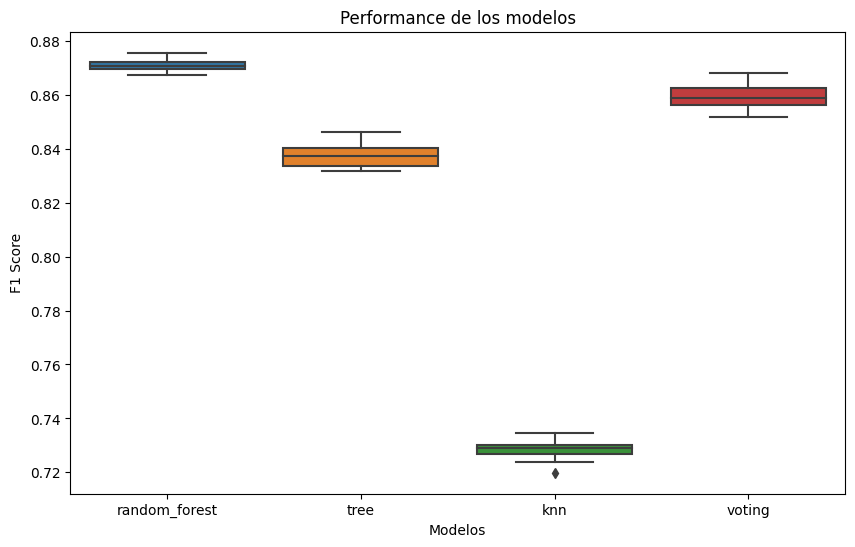

In [78]:
#Grafico performance
plt.figure(figsize=(10,6))
sns.boxplot(resultado).set(xticklabels=nombres, title='Performance de los modelos', xlabel='Modelos', ylabel='F1 Score')
plt.show()

### Submission

In [66]:
pickle.dump(modelo_voting, open('voting_grupo29.pickle', 'wb'))

In [ ]:
X_submission_voting = test.select_dtypes(exclude=['object'])
y_pred_test_voting = modelo_voting.predict(X_submission_voting)
df_submission_voting = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_voting})
df_submission_voting.to_csv('voting00.csv', index=False)

## Stacking Classifier

Creamos los modelos a utilizar

In [67]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=60)
knn = KNeighborsClassifier(n_neighbors=3)
xgboost = xgb.XGBClassifier(random_state=RANDOM_STATE)

Evaluamos los modelos por separado

In [68]:
base_models = {'random_forest': rf,
               'knn': knn,
               'xgboost': xgboost}

result, names = list(), list()
for name, model in base_models.items():
	scores = score(model, x_train, y_train)
	result.append(scores)
	names.append(name)
	print('%s %.3f' % (name, mean(scores)))

random_forest 0.873
knn 0.743
xgboost 0.871


Creamos el Stacking Classifier, lo entrenamos con los datos y obtenemos las predicciones

In [72]:
#Modelos Base
modelos_base = [('random_forest', rf), ('knn', knn), ('xgboost', xgboost)]

#Meta Modelo
meta_model = LogisticRegression()

#Ensemble Stacking
stacking = StackingClassifier(estimators=modelos_base, final_estimator=meta_model, cv=5)

modelo_stacking = stacking.fit(x_train, y_train)

y_pred = stacking.predict(x_test)

In [73]:
score_stacking = score(stacking, x_train, y_train)
print('Stacking Classifier:', mean(score_stacking))

Stacking Classifier: 0.8781978976988492


In [74]:
result.append(score_stacking)
names.append('stacking')

In [75]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8801756587202008
Recall: 0.8856684755796744
Precision: 0.8795933365997061
f1 score: 0.8826204523107178


In [76]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7832
           1       0.88      0.89      0.88      8108

    accuracy                           0.88     15940
   macro avg       0.88      0.88      0.88     15940
weighted avg       0.88      0.88      0.88     15940



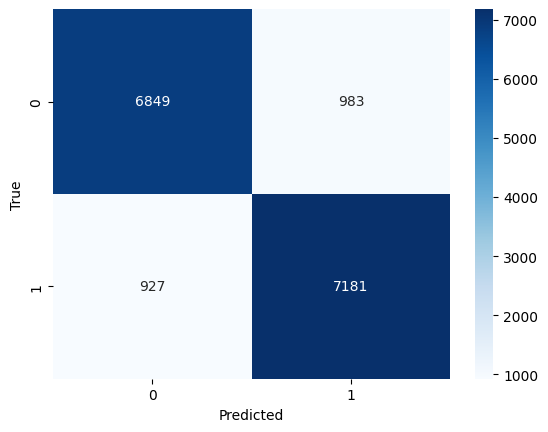

In [80]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

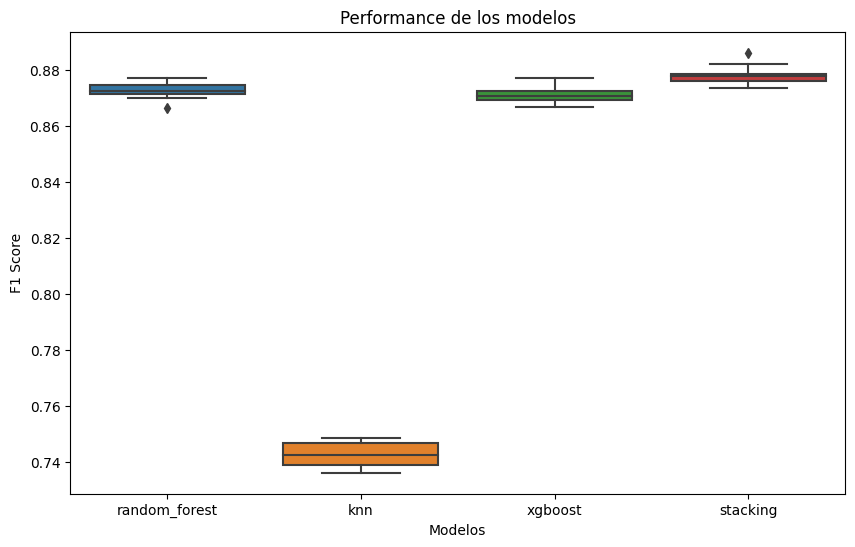

In [81]:
#Grafico performance
plt.figure(figsize=(10,6))
sns.boxplot(result).set(xticklabels=names, title='Performance de los modelos', xlabel='Modelos', ylabel='F1 Score')
plt.show()

### Submission

In [82]:
pickle.dump(modelo_stacking, open('stacking_grupo29.pickle', 'wb'))

In [ ]:
X_submission_stacking = test.select_dtypes(exclude=['object'])
y_pred_test_stacking = modelo_stacking.predict(X_submission_stacking)
df_submission_stacking = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_stacking})
df_submission_stacking.to_csv('stacking00.csv', index=False)